In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from keras.datasets import cifar10
import cv2
from scipy import fft
import math

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


# Download the CIFAR-10 dataset

In [2]:
(train_X_rgb, train_Y_int), (test_X_rgb, test_Y_int) = cifar10.load_data()

In [3]:
### train_X consists of color images. we transform the image into grayscale using opencv library and store it in train_X_gray
train_X_gray = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in train_X_rgb])

# Processing Data
### Flatten image to create train_X, train_Y

In [4]:
train_X = np.ndarray(shape=(50000, 32*32))
for i in range(50000):
    train_X[i] = train_X_gray[i].flatten()
        
train_X = np.transpose(train_X)

In [5]:
train_Y = np.zeros(shape = (50000, 10))
for i in range(50000):
    train_Y[i][train_Y_int[i][0]] = 10000

train_Y = np.transpose(train_Y)

# Full Batch Sigma_xx & Sigma_yx, W_optimal

In [6]:
### Calculate sigma_xx, sigma_yx for the full dataset

sigma_xx_full = np.zeros((1024, 1024))
sigma_yx_full = np.zeros((10, 1024))

for i in range(50000):
    x = train_X[:,i].reshape((1024,1))
    y = train_Y[:,i].reshape((10,1))
    sigma_xx_full += x * x.T
    sigma_yx_full += y * x.T
    
sigma_xx_full = sigma_xx_full / 50000.0
sigma_yx_full = sigma_yx_full / 50000.0

In [7]:
sigma_xx_inv = np.linalg.inv(sigma_xx_full)

In [8]:
W_optimal = np.matmul(sigma_yx_full, sigma_xx_inv)

# Define Error

In [9]:
def getCosError(W1, W2):
    ### returns (1-cosine) value of the angle between two "vectors" W1 and W2
    return 1.0-(np.sum(np.multiply(W1, W2)) / (np.linalg.norm(W1) * np.linalg.norm(W2)))

# Mini Batch Gradient Descent

In [10]:
### randomly select a minibatch and compute sigma_xx, sigma_yx
def generate_minibatch(batch_size):
    sample = random.sample(range(50000), batch_size)
    x_minibatch = train_X[:,sample]
    y_minibatch = train_Y[:,sample]
    
    sigma_xx = np.zeros((1024, 1024))
    sigma_yx = np.zeros((10, 1024))
    for i in range(batch_size):
        x = x_minibatch[:,i].reshape((1024,1))
        y = y_minibatch[:,i].reshape((10,1))
        sigma_xx += x * x.T
        sigma_yx += y * x.T
        
    sigma_xx = sigma_xx / batch_size
    sigma_yx = sigma_yx / batch_size
    return (sigma_xx, sigma_yx)

In [11]:
#randomly initialize W
W = W_optimal + 0.5*np.random.randn(10, 1024)

In [12]:
max_epochs = 800000
converging_range = 80000

learning_rate = 0.0000002
error_list = []

###list to save W's and sigma_yx's for later analysis
W_list=[]
sigma_yx_list=[]

for epoch in range(0, max_epochs + 1):
    ###calculating error for every 100th epoch to reduce running time
    if epoch % 100 == 0:
      error_list.append(getCosError(W, W_optimal))
    
    #generating minibatch
    (mb_sigma_xx,mb_sigma_yx)=generate_minibatch(500)
    
    #saving W's and sigma_yz's only in converging range
    if epoch > max_epochs - converging_range:
        W_list.append(W)
        sigma_yx_list.append(mb_sigma_yx)
    
    #gradient descent
    W = W + learning_rate*np.matmul(-W, mb_sigma_xx) + learning_rate*mb_sigma_yx

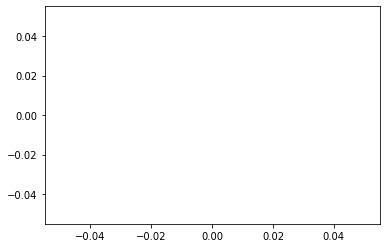

In [13]:
#plotting error list to see convergence
plt.plot(error_list[1:])

# Defining Sigma WW, D, and SigmaXXSigmaWW+SigmaWWSigmaXX

In [14]:
sigma_WW=np.zeros((1024,1024))
D=np.zeros((1024,1024))
interval_length=len(W_list)

for n in range(interval_length):
    W = W_list[n] - W_optimal
    sigma_WW += np.matmul(W.T,W)
    sigma_yx = sigma_yx_list[n] - sigma_yx_full
    D += np.matmul(sigma_yx.T,sigma_yx)
    
sigma_WW/=interval_length
D/=interval_length
sigma_XXWW = np.matmul(sigma_xx_full,sigma_WW)+np.matmul(sigma_WW,sigma_xx_full)

# Matrix Contour Plots

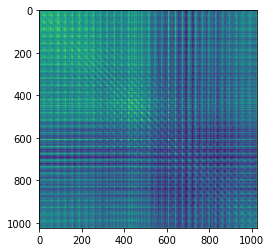

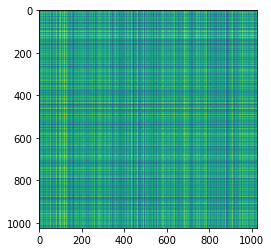

In [15]:
#Contour plot of D
plt.imshow(D, interpolation = 'nearest')
plt.show()
#Contour plot of SigmaXXSigmaWW+SigmaWWSigmaXX
plt.imshow(sigma_XXWW, interpolation = 'nearest')
plt.show()

# FFT Analysis of D and SigmaXXSigmaWW+SigmaWWSigmaXX

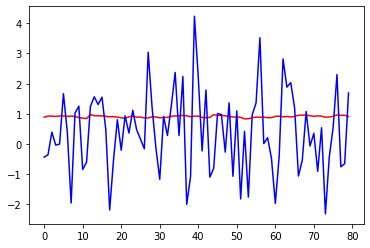

In [16]:
DPI = 200
output_range = 500
brightness_adjusting_factor = 1

def to_image(complex_input):
     output = np.abs(complex_input)**(1/brightness_adjusting_factor)
     return output

def plott(im, title=""):
    if (type(im[0,0]) == np.complex128):
        im = to_image(im)
    fig = plt.figure(dpi=DPI)
    plt.matshow(im)
    plt.title(title)
    
n = 0
X = []
Y = []

a=20
b=100
for i in range(a,b): #First row of FFT of D
     x = D[0][i]
     X.append(x)
for i in range(a,b): #First row of FFT of sigma_XXWW
     y = sigma_XXWW[0][i]
     Y.append(y)
t = np.arange(a,b,1)

plt.figure(1)
plt.plot(X/D[0][0],'r');
plt.plot(Y/sigma_XXWW[0][0],'b')
plt.show()

# Q Analysis

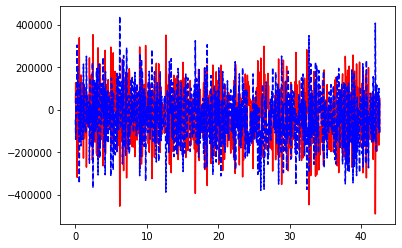

0.9477770817566179
0.9973366710457976


In [17]:
A = np.matmul(sigma_WW,sigma_xx_full) + np.matmul(sigma_xx_full, sigma_WW) # D matrix
B = np.matmul(sigma_WW,sigma_xx_full) - np.matmul(sigma_xx_full, sigma_WW) # Q matrix

x = 0
y = 0

X = []
Y = []

## graphing 10th row of D and Q matrices
for i in range(0, 1024):
     x = A[10][i]
     X.append(x)
for i in range(0, 1024):
     y = B[10][i]
     Y.append(y)

t = np.arange(0, 1024,1)
plt.figure(1)
plt.plot(t/24, X,'r')
plt.plot(t/24, Y,'b--')
plt.show()

print(abs(B).max()/abs(A).max()) # Comparing maximum value of D and Q matrices
print(abs(B).sum() / abs(A).sum()) # Comparing sum of absolute value of D and Q matrices' elements

# FFT Analysis of Q

<Figure size 432x288 with 0 Axes>

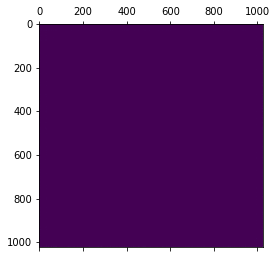

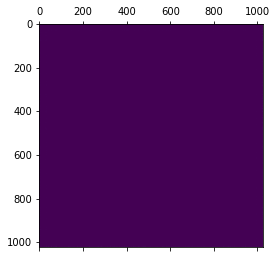

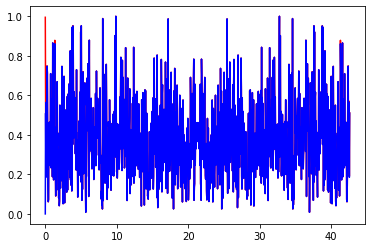

In [18]:
A_fft = np.abs(fft.fft2(A)) # FFT of D matrix and absolute braket for plotting
B_fft = np.abs(fft.fft2(B)) # FFT of Q matrix and absolute braket for plotting

plt.figure(1)
plt.matshow(A_fft)
plt.figure(2)
plt.matshow(B_fft)
plt.show()

E = []
G = []
for i in range(0, 1024):
     e = A_fft[0][i]/(A_fft.max()) # first row of normalised FFT of D
     E.append(e)
for i in range(0, 1024):
     g = B_fft[0][i]/(B_fft.max()) # first row of normalised FFT of Q
     G.append(g)
t = np.arange(0, 1024,1)

plt.figure(1)
plt.plot(t/24, E,'r')
plt.plot(t/24, G,'b')

plt.show()